In [1]:
import rgrow as rg

In [11]:
tileset = rg.TileSet(
    [
        rg.Tile(name="S", edges=["null", "rb", "bb", "null"], color="purple", stoic=0),
        rg.Tile(name="RB", edges=["null", "rb", "e1", "rb"], color="red"),
        rg.Tile(name="BB", edges= ["bb", "e1", "bb", "null"], color="blue"),
        rg.Tile(name="00", edges= ["e0", "e0", "e0", "e0"], color="teal"),
        rg.Tile(name="10", edges= ["e1", "e1", "e1", "e0"], color="green"),
        rg.Tile(name="01", edges= ["e0", "e1", "e1", "e1"], color="yellow"),
        rg.Tile(name="11", edges= ["e1", "e0", "e0", "e1"], color="orange"),
    ],
    bonds=[rg.Bond("rb", 2), rg.Bond("bb", 2)],
    seed=[
        (2,2, "S")
    ],
    gmc=16,
    gse=8.5,
    size=(32,32),
    canvas_type="SquareCompact",
)

In [12]:
system, state = tileset.create_system_and_state()

In [14]:
system.evolve(state, for_events=10000)

EvolveOutcome.ReachedEventsMax

<Axes: >

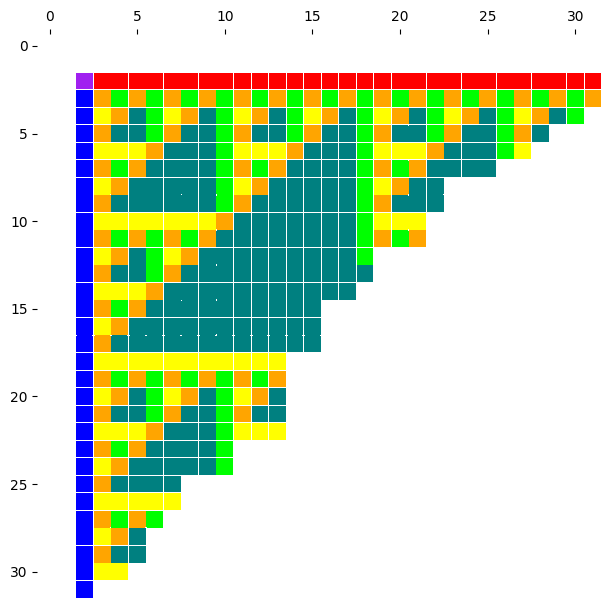

In [15]:
system.plot_canvas(state)

In [38]:
state = tileset.create_state() # make a new empty (except for seed) state
system.evolve(state, 
    show_window=True,     # show the UI
    initial_timescale=100, # lock timescale to be no more than 100x real time.
)

EvolveOutcome.ReachedTimeMax